In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import lightcones.linalg as ll
from scipy.sparse.linalg import eigsh, eigs
import scipy.sparse as sparse
from scipy.spatial.distance import cdist

In [20]:
epsilon = 0.1
dt = 0.01
t_past = 40
t_future = 40 

In [21]:
n_rel = 10

In [22]:
t_max = t_past + t_future
t = np.arange(0, t_max, dt)
n_t_max = len(t)

In [23]:
n_t_past = int(t_past / dt)
n_t_future = int(t_future / dt)

In [24]:
M = np.zeros(n_t_max) 
for i in range(n_t_max):
    M[i] = epsilon / (epsilon**2 + (t[i] - t[0])**2)

In [25]:
def apply_memory_matrix(x):
    x_out = np.zeros(n_t_past)
    for i in range(n_t_future):
        m = M[i:i+n_t_past]
        x_out = x_out + np.vdot(m, x) * m
    return x_out

memory_matrix = sparse.linalg.LinearOperator((n_t_past, n_t_past), matvec=apply_memory_matrix)

In [26]:
def ensure_phase(eigenvectors):
    eigenvectors_corrected = eigenvectors.copy()
    
    for i in range(eigenvectors.shape[1]):
        v = eigenvectors[:, i]
        idx_max = np.argmax(np.abs(v))
        
        if v[idx_max] < 0:
                eigenvectors_corrected[:, i] = -v         
    return eigenvectors_corrected

In [27]:
# zero approximation for relevant vectors
pi, v = eigsh(memory_matrix, k=n_rel, which='LM')
v = ensure_phase(v)

In [28]:
v_in = np.zeros(n_t_past)
v_in[0] = 1

In [29]:
def iterate(v):
    v_shifted = np.vstack((np.zeros(n_rel), v[:-1, :]))
    U = np.column_stack((v_in, v_shifted))
    rho = U.T.conj() @ (memory_matrix @ U)
    pi_, U_ = ll.find_eigs_descending(rho)
    U_ = ensure_phase(U_)
    v_ = U @ U_
    return pi_, U_, v_ 

In [30]:
pi_lst = []
U_lst = []
v_lst = []

v_ = np.copy(v)

for i in range(1000):
    pi_, U_, v_ = iterate(v_)
    pi_lst.append(pi_)
    U_lst.append(U_)
    v_lst.append(v_)
    v_ = np.copy(v_)
    v_ = v_[:,:-1]

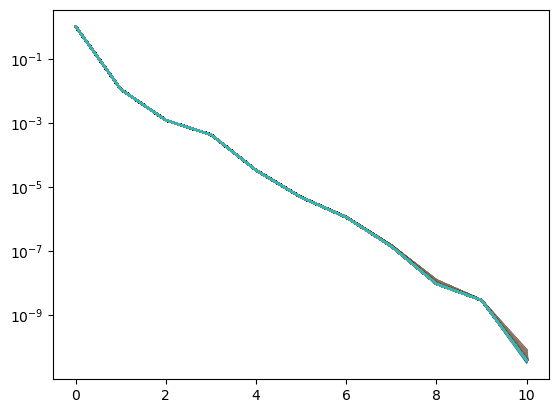

In [31]:
plt.yscale('log')
for i in range(1000):
    pi_ = pi_lst[i]
    plt.plot(pi_ / pi_[0])

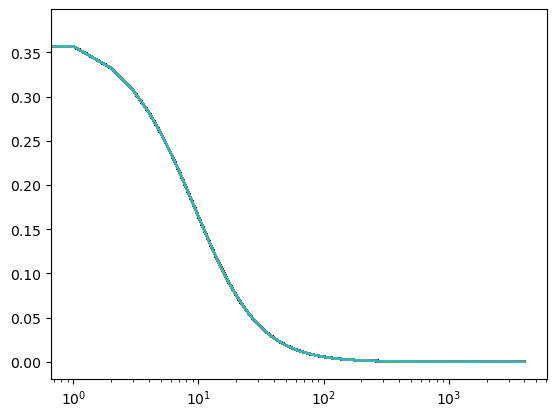

In [32]:
plt.xscale('log')
for i in range(1000):
    v_ = v_lst[i]
    psi = v_[:, 0]
    plt.plot(psi)

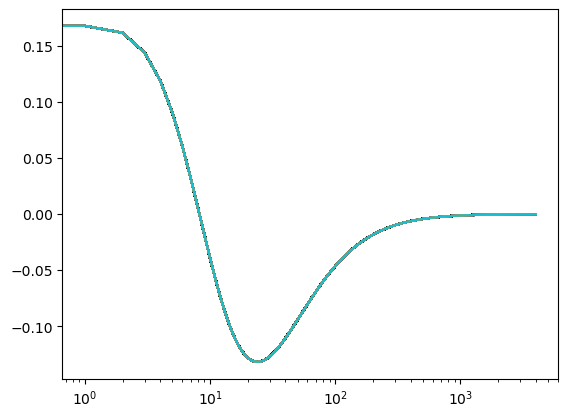

In [33]:
plt.xscale('log')
for i in range(1000):
    v_ = v_lst[i]
    psi = v_[:, 1]
    plt.plot(psi)

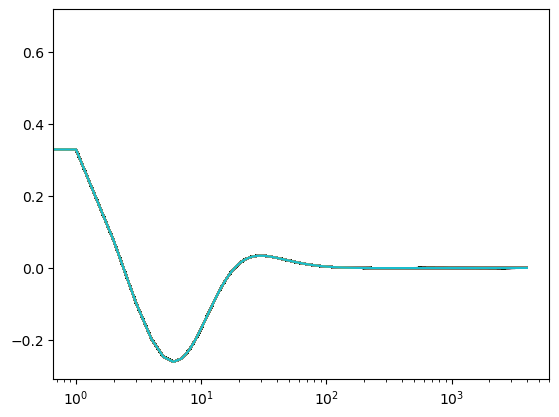

In [34]:
plt.xscale('log')
for i in range(1000):
    v_ = v_lst[i]
    psi = v_[:, 2]
    plt.plot(psi)

np.float64(3.926684583329996e-11)

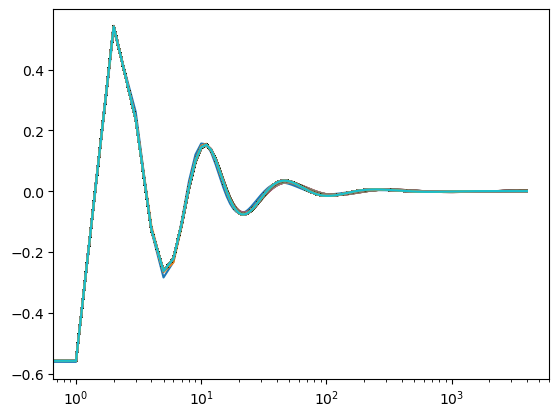

In [35]:
# outgoing mode
plt.xscale('log')
for i in range(1000):
    v_ = v_lst[i]
    psi = v_[:, -1]
    plt.plot(psi)

pi_ = pi_lst[i]
pi_[-1] / pi_[0]

In [36]:
d_lst = []
U_prev = U_lst[0]
for i in range(1, 1000):
    U_ = U_lst[i]
    d = np.linalg.norm(U_ - U_prev)
    d_lst.append(d)
    U_prev = np.copy(U_)

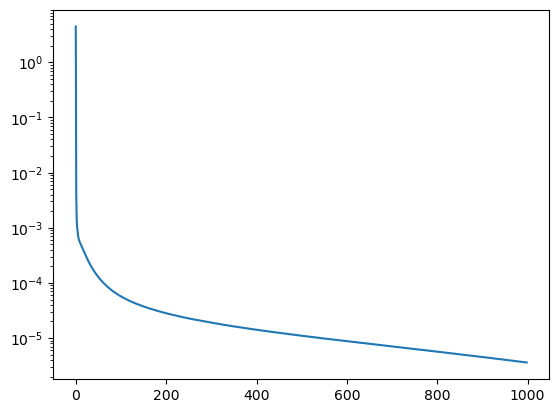

In [37]:
plt.yscale('log')
plt.plot(d_lst)